# Text Scraping and Classification 


The objective of this script is to scrape a corpus of news articles from a set of web pages, pre-process the corpus, and evaluate the performance of automated classification of these articles. 

This script uses a number of external python libraries such as BeautifulSoup, Sklearn, Matplotlib and NLTK, which will all be explained as they arise in the solution.

In [20]:
import bs4
import urllib.request
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from plot_confusion_matrix import plot_confusion_matrix
import numpy as np

Step 1 - Data Collection

In this section of the script, the focus will be on scraping the news articles and categories from their respective websites, with the appropriate filtering, and storing the results in text files for analysis in the next step. 

Firstly, in order to initiate the web scraping process, a HTTP request needs to be made to the website. This is done via the Python module, urllib.request. Urllib.request is a module used for reading and retrieving information from websites. 

Secondly, after the response from the website is read and verified, a html parser will be called to read in the html code. This is done using the 3rd party library, BeautifulSoup. BeautifulSoup is a Python library that is used to extract data from HTML and XML files. In this case, we will be using it HTML parser. 

As the website that is being analysed for this script has a number of subpages, the process should be to retrieve the web links to the web pages that the articles are on,retrieve the categories of each articles, navigate to each article and save the article text. This requires a number of HTTP requests and as such a number of nested try statements. 

In [21]:
link = 'http://mlg.ucd.ie/modules/COMP41680/archive/'
filter_one = 'Return to article search results'
filter_two = 'Comments are closed for this article.'

The filters, filter_one and filter_two are text filters that appear on some of the articles which are not part of the body of the article itself, but whose HTML code is indistinguishable from the rest of the article. These lines are ommitted from being scraped, as are categories titled 'N/A'. 

This process can take some time, particularly depending on the quality of the internet connection, so a print statement was added in at the end for when the scraping is finished.

After the content is retrieved and parsed, the content is saved to two text files, words.txt for the article contents, and categories.txt for the category labels.

In [24]:
try:
    #First search for main index page 
    response = urllib.request.urlopen(link + '/index.html')
    html = response.read().decode()
    urls = []
    parser = bs4.BeautifulSoup(html, 'html.parser')
    #Retrieves all the links for the monthly articles pages
    #Saves the results in the urls list
    ul_list = parser.find('ul')
    li_list = ul_list.find_all('li')
    for li in li_list:
        url = li.find('a', href=True)
        urls.append(url['href'])
    categories = []
    new_urls = []
    words = []
    for url in urls:
        nav_url = link + url
        try:
            #Second search for articles and categories per month 
            url_response = urllib.request.urlopen(nav_url)
            url_response = url_response.read().decode()
            url_parser = bs4.BeautifulSoup(url_response, 'html.parser')
            for match in url_parser.find_all("a", href=True):
                new_urls.append(match['href'])
            table = url_parser.find('table', attrs={'class': 'table-condensed'})
            table_body = table.find('tbody')
            rows = table_body.find_all('tr')
            #Collecting the categories per article per month page
            for row in rows:
                cols = row.find_all('td')
                cols = [ele.text.strip() for ele in cols]
                if cols[0] != 'N/A':
                    #List to hold the categories
                    categories.append(cols[0])
                    words_url = row.find('a', href=True)
                    if words_url is not None:
                        words_url_request = link + words_url['href']
                        try:
                            #Third search to access each article
                            words_url_response = urllib.request.urlopen(words_url_request)
                            words_url_response = words_url_response.read().decode()
                            words_parser = bs4.BeautifulSoup(words_url_response, 'html.parser')
                            word_data = words_parser.find_all('div', attrs={'class': 'main'})
                            for rows in word_data:
                                title = rows.find_all('b')
                                title = [ele.text.strip() for ele in title]
                                data = rows.find_all('p')
                                data = [ele.text.strip() for ele in data]
                                for lines in data:
                                    if lines == filter_one or lines == filter_two:
                                        pass
                                    else:
                                        title.append(lines)
                                #List to hold the article content
                                words.append(title)
                        except urllib.error.HTTPError as e:
                            print(e.reason + ' 3rd Try ' + words_url_request)
        except urllib.error.HTTPError as e:
            print(e.reason + ' 2nd Try ' + nav_url)
except urllib.error.HTTPError as e:
    print(e.reason + ' 1st Try ' + link)
    
print('Web Scrape Complete')

Web Scrape Complete


In [25]:
with open('categories.txt', 'w') as cat_file:
    for data in categories:
        cat_file.write("%s\n" % data)
cat_file.close()

with open('words.txt', 'w') as word_file:
    for articles in words:
        for lines in articles:
            word_file.write("%s " % lines)
        word_file.write('\n')
word_file.close()

Step 2 - Text Classification

Firstly, the text needs to be extracted from the text files. A method was created to extract the data from the file, strip unnecessary punctuation and return a list with the data.

In [26]:
#Method to extract text from files
def get_data_from_file(file):
    raw_documents = []
    with open(file, 'r') as word_file:
        for lines in word_file:
            raw_documents.append(lines.strip())
    word_file.close()
    return raw_documents

docs = get_data_from_file('words.txt')
cats = get_data_from_file('categories.txt')

Next, the data needs to be split into training data and test data. Training data is the data that is used to teach the models how to classify new data. Test data is the data that will be used to see how accurate the models are in their predictions. In this assignment, a 80/20 split between training data and test data was chosen. This ratio can be as high as 2:1, but 80/20 is sufficient for this analysis. 

In [27]:
train_docs, test_docs, train_cats, test_cats = train_test_split(docs, cats, test_size=0.2)

Next, the data needs to go through a phase known as pre-processing. This is the process of removing unnecessary or insignificant data points, as well as amalgamating like data points. 

Specifically, it was decided that terms that appeared less than 5 times would be discarded. A 'stop word' list was also applied. This is a list of words of very common but non-descriptive words that do no contribute to the classification of the data. Stemming was also applied, which is the process of removing tail endings to words in order to group more words by their core meaning. An example would be stemming computers, computing and compute to comput. 

This pre-processing was then term-weighted using a TD-IDF (term frequency–inverse document frequency) vector. This is a statistical measure of how important a word is based on how often a word appears in a given body of text. 

In [28]:
#Build stem tokenizer
def stem_tokenizer(text):
    # use the standard scikit-learn tokenizer first
    standard_tokenizer = CountVectorizer().build_tokenizer()
    tokens = standard_tokenizer(text)
    # then use NLTK to perform stemming on each token
    stemmer = PorterStemmer()
    stems = []
    for token in tokens:
        stems.append(stemmer.stem(token))
    return stems

#Creating the TD-IDF Matrix with pre-processing
tf_idf_vectorizer = TfidfVectorizer(min_df=5, strip_accents='ascii', stop_words='english', tokenizer=stem_tokenizer)
tf_idf_vector = tf_idf_vectorizer.fit_transform(train_docs)

The next step is to build the models. In this assignment, the task is to compare two different modelling types. The two types chosen were a K-Neighbours model and a Support Vector Machine model, specifically a linear support vector classifier. These classifiers were chosen because they are commonly used in document analysis and as such it is an apt opportunity to compare the two. 

A model of each was built, with the number of neighbours for the K-Neighbours model chosen to be three, and the training data from the TD-IDF vector was applied to each. The test data was applied to the same TF-IDF vector and predictions were made. 

In [29]:
#Building models with the training categories
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(tf_idf_vector, train_cats)
svc_model = LinearSVC()
svc_model.fit(tf_idf_vector, train_cats)

#Fitting the test data
test_data = tf_idf_vectorizer.transform(test_docs)

#Obtaining the prediction data from the test data
knn_predict = knn_model.predict(test_data)
svc_predict = svc_model.predict(test_data)

The output of the prodictions cane be seen below.

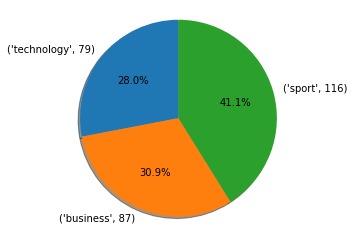

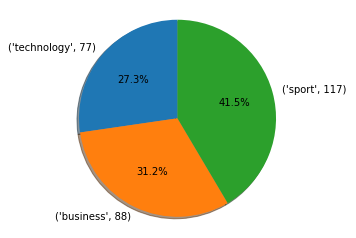

In [30]:
#Getting a count of the prediction data
knn_data = Counter(knn_predict)
svc_data = Counter(svc_predict)
target_names = list(set(train_cats))

#Plotting the predicted data results
fig1, ax1 = plt.subplots()
ax1.pie(knn_data.values(), labels=knn_data.items(), autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

fig2, ax2 = plt.subplots()
ax2.pie(svc_data.values(), labels=svc_data.items(), autopct='%1.1f%%',
        shadow=True, startangle=90)
ax2.axis('equal')
plt.show()

Step 3 - Evaluation

The first evaluation is a simple accuracy measurement. This is the number of correct answers versus the correct data.

In [31]:
#Calculating the accuracy of the models
knn_accuracy = accuracy_score(test_cats, knn_predict)
svc_accuracy = accuracy_score(test_cats, svc_predict)

print(round(knn_accuracy, 3))
print(round(svc_accuracy, 3))

0.95
0.979


The next evalution measurement is a confusion matrix. A confusion matrix shows where the errors occur. In this assignment, it can show which documents were incorrectly labelled and which label they were incorrectly labelled with.

Confusion matrix, without normalization
[[ 84   1   7]
 [  2 112   0]
 [  1   3  72]]
Confusion matrix, without normalization
[[ 88   1   3]
 [  0 114   0]
 [  0   2  74]]


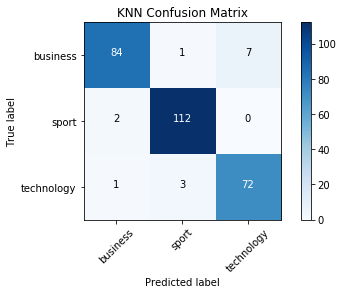

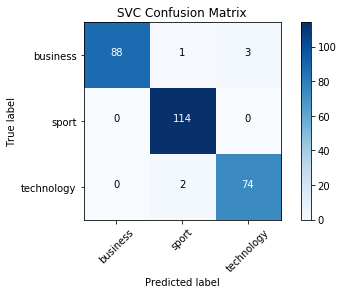

In [32]:
import itertools

#Building a confusion matrix per model
knn_cm = confusion_matrix(test_cats, knn_predict)
svc_cm = confusion_matrix(test_cats, svc_predict)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
#Plotting the confusion matrices
plt.figure()
plot_confusion_matrix(knn_cm, classes=target_names, title='KNN Confusion Matrix')
plt.figure()
plot_confusion_matrix(svc_cm, classes=target_names, title='SVC Confusion Matrix')
plt.show()

The next performance metric is a classification report. This shows a table of the precision, recall and F1 scoring of each label, as well as the average result for each report. 

In [33]:
#Building a performance report
knn_report = classification_report(test_cats, knn_predict, target_names=target_names)
svc_report = classification_report(test_cats, svc_predict, target_names=target_names)

print(knn_report)
print(svc_report)

             precision    recall  f1-score   support

   business       0.97      0.91      0.94        92
      sport       0.97      0.98      0.97       114
 technology       0.91      0.95      0.93        76

avg / total       0.95      0.95      0.95       282

             precision    recall  f1-score   support

   business       1.00      0.96      0.98        92
      sport       0.97      1.00      0.99       114
 technology       0.96      0.97      0.97        76

avg / total       0.98      0.98      0.98       282



However, the most important performance metric would be the k-Fold Cross Validation tests. Earlier in the assignment, it was seen that the data was split 80/20 for training and test data. However, as this split is random, it can be difficult to ensure that the results are not random. A k-Fold Cross Validation test, divides the data into a number of folds, splits the data into training and test data and then repeats the experiments while calculating the accuracy and error rates. As this repeats over the data a number of times, the likelihood of random results decreases. 

In this case a new TD-IDF vector and model were built and five folds were chosen for the tests for each model.

In [34]:
#Creating a cross validation test for both models
knn_clf = Pipeline([('vect', TfidfVectorizer()), ('knn', KNeighborsClassifier(n_neighbors=3))])
knn_acc_scores = cross_val_score(knn_clf, train_docs, train_cats, cv=5, scoring="accuracy")
svc_clf = Pipeline([('vect', TfidfVectorizer()), ('svc', LinearSVC())])
svc_acc_scores = cross_val_score(svc_clf, train_docs, train_cats, cv=5, scoring="accuracy")

The accuracy markers from a single test and the average accuracy from a k-Fold Cross Validation test can then be compared. 

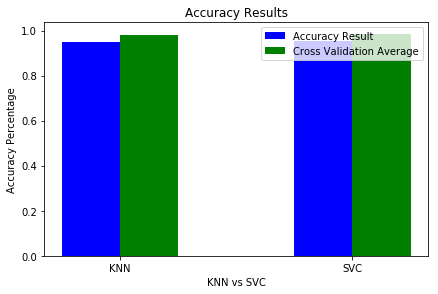

Results are a single test
0.95
0.979
Average results from the k-Folds Cross Validation Test
0.956
0.987


In [35]:
#Plotting the accuracy results
plt.figure()
knn_accuracy_data = (knn_accuracy, knn_acc_scores.mean())
svc_accuracy_data = (svc_accuracy, svc_acc_scores.mean())
width = 0.25
x = np.arange(2)
ax = plt.subplot()
k = ax.bar(x, knn_accuracy_data, width, color='blue')
s = ax.bar(x + width, svc_accuracy_data, width, color='green')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(('KNN', 'SVC'))
ax.legend((k, s), ('Accuracy Result', 'Cross Validation Average'))
plt.title('Accuracy Results')
plt.tight_layout()
plt.ylabel('Accuracy Percentage')
plt.xlabel('KNN vs SVC')
plt.show()

print('Results are a single test')
print(round(knn_accuracy, 3))
print(round(svc_accuracy, 3))

print('Average results from the k-Folds Cross Validation Test')
print(round(knn_acc_scores.mean(), 3))
print(round(svc_acc_scores.mean(), 3))

In conclusion, after a number of tests it was seen that overall the SVC model is more accurate after both a single test and a k-folds cross validation test than the K-Nearest Neighbours model. The K-Nearest Neighbours model can be tuned to look for more neighbours, in this case three was chosen, but the methods to choose a more accurate K value were not explored in this assignment. The K-Nearest Neighbours can also be quite susceptible to noise. This is why the pre-processing is so important. It is possible that using a technique known as lemmatisation instead of stemming could make the data more accurate. Lemmatisation is the process of reducing a term to its canonical form. However, this can be difficult to implement without in depth knowledge of the language being analysed. However, this could potentially improve the performance of both models. 